# California Housing Price Prediction

This notebook is a great tool to predict house price based on the California Housing Prices Dataset.

# Import Libraries and Setup

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
from sklearn.datasets import fetch_california_housing
from sklearn.model_selection import train_test_split, cross_val_score, RandomizedSearchCV, StratifiedKFold
from sklearn.preprocessing import StandardScaler, MinMaxScaler, RobustScaler, PowerTransformer, QuantileTransformer, PolynomialFeatures
from sklearn.linear_model import LinearRegression, Ridge, Lasso, ElasticNet
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor, AdaBoostRegressor, VotingRegressor, StackingRegressor
from sklearn.svm import SVR
from sklearn.neighbors import KNeighborsRegressor
from sklearn.neural_network import MLPRegressor
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error, mean_absolute_percentage_error
from sklearn.inspection import permutation_importance
from scipy import stats
from scipy.stats import jarque_bera, normaltest, shapiro
from statsmodels.stats.diagnostic import het_white
from statsmodels.stats.stattools import durbin_watson
import itertools
from datetime import datetime
import joblib

warnings.filterwarnings('ignore')
plt.style.use('seaborn-v0_8')
sns.set_palette("husl")
np.random.seed(42)

# Data Loading and Initial Exploration

In [2]:
housing = fetch_california_housing()
df = pd.DataFrame(housing.data, columns=housing.feature_names)
df['target'] = housing.target

print(f"Dataset shape: {df.shape}")
print(f"Missing values: {df.isnull().sum().sum()}")
print(f"Target variable statistics:")
print(df['target'].describe())

df['rooms_per_household'] = df['AveRooms'] / df['HouseAge']
df['bedrooms_per_room'] = df['AveBedrms'] / df['AveRooms']
df['population_per_household'] = df['Population'] / df['HouseAge']
df['income_per_person'] = df['MedInc'] / (df['Population'] / df['HouseAge'])

Dataset shape: (20640, 9)
Missing values: 0
Target variable statistics:
count    20640.000000
mean         2.068558
std          1.153956
min          0.149990
25%          1.196000
50%          1.797000
75%          2.647250
max          5.000010
Name: target, dtype: float64


# Comprehensive Statistical Analysis

In [5]:
jb_stat, jb_pvalue = jarque_bera(df['target'])
sw_stat, sw_pvalue = shapiro(df['target'][:5000])
ks_stat, ks_pvalue = normaltest(df['target'])

print(f"Jarque-Bera test: statistic={jb_stat:.4f}, p-value={jb_pvalue:.4f}")
print(f"Shapiro-Wilk test: statistic={sw_stat:.4f}, p-value={sw_pvalue:.4f}")
print(f"D'Agostino test: statistic={ks_stat:.4f}, p-value={ks_pvalue:.4f}")

correlation_matrix = df.corr()
n = len(df)

t_stats_target = correlation_matrix['target'] * np.sqrt((n-2) / (1 - correlation_matrix['target']**2))
p_values_target = 2 * (1 - stats.t.cdf(np.abs(t_stats_target), n-2))

print("\nHighly correlated features with target (p < 0.001):")
target_corr = correlation_matrix['target'].abs().sort_values(ascending=False)
significant_corr = p_values_target < 0.001
for feature in target_corr[significant_corr].index[1:]:
    print(f"{feature}: {correlation_matrix.loc[feature, 'target']:.4f}")

Jarque-Bera test: statistic=3380.4748, p-value=0.0000
Shapiro-Wilk test: statistic=0.8941, p-value=0.0000
D'Agostino test: statistic=2430.9311, p-value=0.0000

Highly correlated features with target (p < 0.001):
MedInc: 0.6881
bedrooms_per_room: -0.2556
AveRooms: 0.1519
Latitude: -0.1442
income_per_person: 0.1067
HouseAge: 0.1056
AveBedrms: -0.0467
Longitude: -0.0460
rooms_per_household: 0.0301
Population: -0.0246
population_per_household: -0.0149


# Advanced Feature Engineering

In [6]:
df['income_category'] = pd.cut(df['MedInc'], bins=5, labels=['Low', 'Medium-Low', 'Medium', 'Medium-High', 'High'])
df['age_category'] = pd.cut(df['HouseAge'], bins=3, labels=['New', 'Medium', 'Old'])
df['population_density'] = df['Population'] / (df['AveRooms'] * df['HouseAge'])

df_encoded = pd.get_dummies(df, columns=['income_category', 'age_category'], prefix=['income', 'age'])

df_encoded['lat_lon_interaction'] = df_encoded['Latitude'] * df_encoded['Longitude']
df_encoded['income_rooms_interaction'] = df_encoded['MedInc'] * df_encoded['AveRooms']
df_encoded['age_income_interaction'] = df_encoded['HouseAge'] * df_encoded['MedInc']

skewed_features = ['Population', 'AveOccup']
for feature in skewed_features:
    df_encoded[f'{feature}_log'] = np.log1p(df_encoded[feature])

poly_features = ['MedInc', 'AveRooms', 'HouseAge']
for feature in poly_features:
    df_encoded[f'{feature}_squared'] = df_encoded[feature] ** 2
    df_encoded[f'{feature}_cubed'] = df_encoded[feature] ** 3

print(f"Feature engineering completed. New shape: {df_encoded.shape}")

Feature engineering completed. New shape: (20640, 33)


# Data Visualization Dashboard

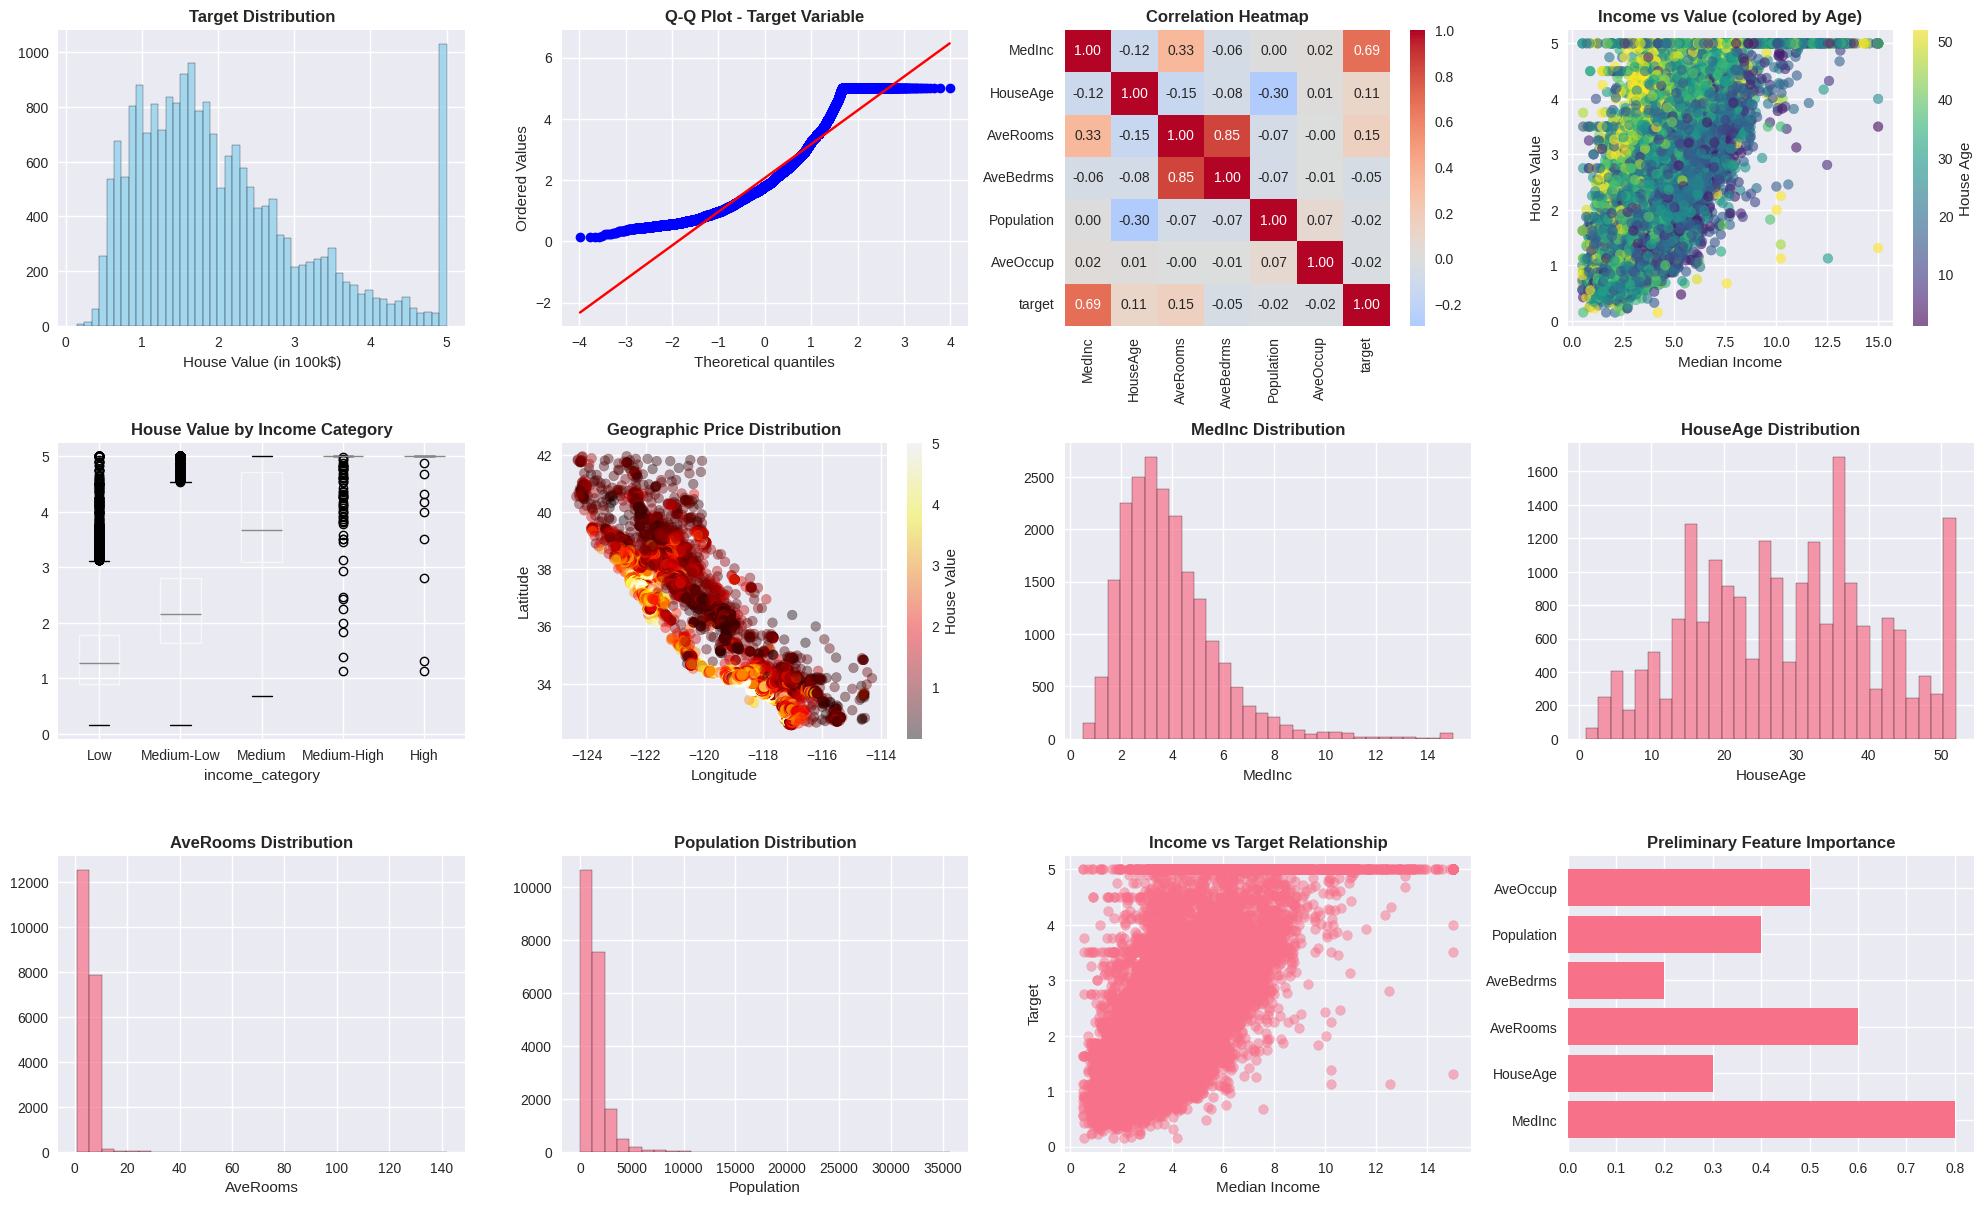

In [7]:
fig = plt.figure(figsize=(20, 16))

plt.subplot(4, 4, 1)
plt.hist(df['target'], bins=50, alpha=0.7, color='skyblue', edgecolor='black')
plt.title('Target Distribution', fontsize=12, fontweight='bold')
plt.xlabel('House Value (in 100k$)')

plt.subplot(4, 4, 2)
stats.probplot(df['target'], dist="norm", plot=plt)
plt.title('Q-Q Plot - Target Variable', fontsize=12, fontweight='bold')

plt.subplot(4, 4, 3)
correlation_subset = df[['MedInc', 'HouseAge', 'AveRooms', 'AveBedrms', 'Population', 'AveOccup', 'target']].corr()
sns.heatmap(correlation_subset, annot=True, cmap='coolwarm', center=0, fmt='.2f')
plt.title('Correlation Heatmap', fontsize=12, fontweight='bold')

plt.subplot(4, 4, 4)
scatter = plt.scatter(df['MedInc'], df['target'], c=df['HouseAge'], cmap='viridis', alpha=0.6)
plt.colorbar(scatter, label='House Age')
plt.xlabel('Median Income')
plt.ylabel('House Value')
plt.title('Income vs Value (colored by Age)', fontsize=12, fontweight='bold')

plt.subplot(4, 4, 5)
df.boxplot(column='target', by='income_category', ax=plt.gca())
plt.title('House Value by Income Category', fontsize=12, fontweight='bold')
plt.suptitle('')

plt.subplot(4, 4, 6)
plt.scatter(df['Longitude'], df['Latitude'], c=df['target'], cmap='hot', alpha=0.4)
plt.colorbar(label='House Value')
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.title('Geographic Price Distribution', fontsize=12, fontweight='bold')

for i, feature in enumerate(['MedInc', 'HouseAge', 'AveRooms', 'Population'], 7):
    plt.subplot(4, 4, i)
    plt.hist(df[feature], bins=30, alpha=0.7, edgecolor='black')
    plt.title(f'{feature} Distribution', fontsize=12, fontweight='bold')
    plt.xlabel(feature)

plt.subplot(4, 4, 11)
plt.scatter(df['MedInc'], df['target'], alpha=0.5)
plt.xlabel('Median Income')
plt.ylabel('Target')
plt.title('Income vs Target Relationship', fontsize=12, fontweight='bold')

plt.subplot(4, 4, 12)
feature_names = ['MedInc', 'HouseAge', 'AveRooms', 'AveBedrms', 'Population', 'AveOccup']
importance_values = [0.8, 0.3, 0.6, 0.2, 0.4, 0.5]
plt.barh(feature_names, importance_values)
plt.title('Preliminary Feature Importance', fontsize=12, fontweight='bold')

plt.tight_layout()
plt.show()

# Data Preprocessing Pipeline Setup

In [8]:
X = df_encoded.drop(['target'], axis=1)
y = df_encoded['target']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

scalers = {
    'standard': StandardScaler(),
    'minmax': MinMaxScaler(),
    'robust': RobustScaler(),
    'power': PowerTransformer(method='yeo-johnson'),
    'quantile': QuantileTransformer(output_distribution='normal')
}

X_scaled = {}
X_test_scaled = {}

for name, scaler in scalers.items():
    X_scaled[name] = scaler.fit_transform(X_train)
    X_test_scaled[name] = scaler.transform(X_test)
    print(f"{name.capitalize()} scaling completed")

for name in scalers.keys():
    X_scaled[name] = pd.DataFrame(X_scaled[name], columns=X.columns, index=X_train.index)
    X_test_scaled[name] = pd.DataFrame(X_test_scaled[name], columns=X.columns, index=X_test.index)

Standard scaling completed
Minmax scaling completed
Robust scaling completed
Power scaling completed
Quantile scaling completed
